In [1]:
import numpy as np
import pandas as pd
# For visualizations
import matplotlib.pyplot as plt
# For regular expressions
import re
# For handling string
import string
# For performing mathematical operations
import math

import swifter
import spacy
import ssl
from spacy import displacy
import pandas as pd
from spacy.lang.en import English
from spacy.pipeline import EntityRuler
from sklearn.metrics import accuracy_score
from spacy.matcher import Matcher
from spacy.pipeline import EntityRuler

from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from fuzzywuzzy import process, fuzz

from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
stop=set(stopwords.words('english'))
#nltk.download('stopwords')

from sklearn.linear_model import LogisticRegression

from joblib import Parallel, delayed

from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt

import seaborn as sns

import re

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing

from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

global cls_acc
cls_acc = 0
global cls_time
cls_time = 0
import time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from IPython.display import display
from IPython.display import display

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import seaborn as sns
from sklearn.metrics import confusion_matrix
from collections import Counter

# EDA - Exploratory Data Anaysis
- Importing the original dataset
- Checking the number of rows and columns of the dataset
- Checking the total of null values per columns
- Checking the total of unique values per column

In [2]:
#df = pd.read_parquet('C:/Users/Olimpio.Dasilva/Desktop/MACHINE LEARNING/DATA/reporting_ncr_all_transactions_202302131044.parquet')
df = pd.read_csv('C:/Users/Olimpio.Dasilva/Desktop/random_sampling/reporting_ncr_all_transactions_202303081506.csv')
#df = pd.read_csv('C:/Users/Olimpio.Dasilva/Desktop/random_sampling/reporting_ncr_all_transactions_202303081406.csv')
pd.set_option('display.max_colwidth', None)
df = df.sample(10000)
df.head(5)

,fi_id,account_id,transaction_id,amount,currency,txn_desc1,txn_desc2,region,transaction_timestamp,merchant_id,merchant_name,payment_agent,payment_agent_id,extract_date,filename,name
797966,DI1460,A4665426520fe31c8994bc891f1af19fe,Tc9136db5a389357d9786eacfd5479187,13.29,USD,Point Of Sale Withdrawal,MCDONALD'S F21664 4215 LAS VEGAS NORTH LAS VEGAS NVUS,NaN,2023-02-01,11840.0,MCDONALD'S,Unknow Payment Agent,NaN,2023-02-04,FTS_CSLK_TRANSAC_20230203_100006.csv,Evansville Teachers Fcu
178055,DI1384,Ad3223d7789b63a15bf558acb5db39386,Tfe2bfc76b3df3ad3be1e426be910812e,5.52,USD,Withdrawal THE HOME DEPOT #4103,BENSALEM PA %% Card 30 #9725 #**,NaN,2023-02-14,11419.0,HOME DEPOT,Unknow Payment Agent,NaN,2023-02-16,FTS_CSLK_TRANSAC_20230215_100006.csv,Philadelphia Fcu
71733,DI3337,A565704f399e7363982f5e6fa50a1aabc,T90fba3e6fdca3b06a16246bef152061a,6.15,USD,Withdrawal Debit Card,McDonald's 11075 148-*0 AZ Date 06/17/22 ***75851 5814,NaN,2022-06-17,11840.0,MCDONALD'S,Unknow Payment Agent,NaN,2022-06-21,FTS_CSLK_TRANSAC_20220620_100007.csv,Arizona Federal Credit Union
716799,DI1041,A6d7f938786fd30cd805967ef862b15c7,T4bb396935c5c3860b30c9a7fd29ca4b6,25.05,USD,Withdrawal MCSIGNATURE,DOORDASH*WENDYS SAN FRANCISCO CA Date 07/30/22 ***30505 5812 %% Card 19 #0074,NaN,2022-07-30,13106.0,WENDY'S,DOORDASH,10891,2022-08-04,FTS_CSLK_TRANSAC_20220803_100006.csv,CLEARVIEW FEDERAL CREDIT UNION
998886,DI3648,Aa3004b24b6db328a9fe64155913f8698,Ta621adab89f1356aac2a52a4951f93fe,17.82,USD,DBT PURCHASE ON 06/01 @ 17:39,JERSEY MIKES ONLINE OR 732-223-4044 NJ CARD NBR: -1347,NaN,2022-06-02,11548.0,JERSEY MIKE'S SUBS,Unknow Payment Agent,NaN,2022-06-05,FTS_CSLK_TRANSAC_20220604_100007.csv,Harborstone Credit Union


In [3]:
print('Total number of rows and columns:', df.shape)

Total number of rows and columns: (10000, 16)


In [4]:
print('Total number of null values per column:')
df.isnull().sum()
#df.dropna(inplace=True)

Total number of null values per column:


fi_id                       0
account_id                  0
transaction_id              0
amount                      0
currency                    0
txn_desc1                   0
txn_desc2                 731
region                   8499
transaction_timestamp       0
merchant_id                 1
merchant_name               0
payment_agent               0
payment_agent_id         9514
extract_date                0
filename                    0
name                        0
dtype: int64

In [5]:
print('Total number of unique values per column:')
df.nunique()

Total number of unique values per column:


fi_id                      160
account_id                9233
transaction_id           10000
amount                    5210
currency                     1
txn_desc1                 3551
txn_desc2                 8456
region                      45
transaction_timestamp      510
merchant_id                698
merchant_name              697
payment_agent               14
payment_agent_id            22
extract_date               482
filename                   530
name                       160
dtype: int64

# Unknown Merchant Names
- Selecting dataset with unknown merchants only
- Checking the number of rows and columns

In [6]:
df_unknown_merchs = df.copy(deep=True)
df_unknown_merchs = df_unknown_merchs[df["merchant_name"].str.contains("Unknow Merchant") == True]
print('Total number of rows and columns:', df_unknown_merchs.shape)

Total number of rows and columns: (0, 16)


# Known Merchant Names
- Selecting known merchants only 
- Checking the number of rows/transactions
- Checking the total number of merchants
- Checking the total number of occurrences per merchant
- Concatenated the transaction details columns
- Defined a function for word cloud for top merchants
- Defined a function for N-gram for top merchants with combined names
- Defined a function to check occurence of merchants in transaction columns

In [7]:
# Selecting only known merchants names from the original dataset
df_known_merchs = df[['transaction_id','txn_desc1','txn_desc2','payment_agent','merchant_name']].copy(deep=True)
df_known_merchs = df_known_merchs[df["merchant_name"].str.contains("Unknow Merchant") == False]
#######
df_known_merchs_cp2 = df[['transaction_id','txn_desc1','txn_desc2','payment_agent','merchant_name']].copy(deep=True)
df_known_merchs_cp2 = df_known_merchs_cp2[df["merchant_name"].str.contains("Unknow Merchant") == False]

#df_known_merchs = df_known_merchs.head(50)

In [8]:
print('Number of transactions with known merchant names:\n',len(df_known_merchs) )

Number of transactions with known merchant names:
 10000


In [9]:
print('Total number of known merchants:\n',len(df_known_merchs.merchant_name.unique()))

Total number of known merchants:
 697


In [10]:
print('Total number of occurences per merchant name:\n',(df_known_merchs.merchant_name).value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

Total number of occurences per merchant name:
 AMAZON.COM     7.8%
WALMART        6.9%
MCDONALD'S     3.5%
APPLE STORE    3.0%
TARGET         2.2%
               ... 
TROPICANA      0.0%
EQUIFAX        0.0%
ULINE          0.0%
HESS           0.0%
HOME CHEF      0.0%
Name: merchant_name, Length: 697, dtype: object


In [11]:
# Concatenating transaction descriptions columns
df_known_merchs["TRANSACTION_DETAILS"] = df_known_merchs['txn_desc1'].astype(str) +" %%%%% "+ df_known_merchs['txn_desc2'].astype(str)

In [12]:
df_known_merchs.head(5)

,transaction_id,txn_desc1,txn_desc2,payment_agent,merchant_name,TRANSACTION_DETAILS
797966,Tc9136db5a389357d9786eacfd5479187,Point Of Sale Withdrawal,MCDONALD'S F21664 4215 LAS VEGAS NORTH LAS VEGAS NVUS,Unknow Payment Agent,MCDONALD'S,Point Of Sale Withdrawal %%%%% MCDONALD'S F21664 4215 LAS VEGAS NORTH LAS VEGAS NVUS
178055,Tfe2bfc76b3df3ad3be1e426be910812e,Withdrawal THE HOME DEPOT #4103,BENSALEM PA %% Card 30 #9725 #**,Unknow Payment Agent,HOME DEPOT,Withdrawal THE HOME DEPOT #4103 %%%%% BENSALEM PA %% Card 30 #9725 #**
71733,T90fba3e6fdca3b06a16246bef152061a,Withdrawal Debit Card,McDonald's 11075 148-*0 AZ Date 06/17/22 ***75851 5814,Unknow Payment Agent,MCDONALD'S,Withdrawal Debit Card %%%%% McDonald's 11075 148-*0 AZ Date 06/17/22 ***75851 5814
716799,T4bb396935c5c3860b30c9a7fd29ca4b6,Withdrawal MCSIGNATURE,DOORDASH*WENDYS SAN FRANCISCO CA Date 07/30/22 ***30505 5812 %% Card 19 #0074,DOORDASH,WENDY'S,Withdrawal MCSIGNATURE %%%%% DOORDASH*WENDYS SAN FRANCISCO CA Date 07/30/22 ***30505 5812 %% Card 19 #0074
998886,Ta621adab89f1356aac2a52a4951f93fe,DBT PURCHASE ON 06/01 @ 17:39,JERSEY MIKES ONLINE OR 732-223-4044 NJ CARD NBR: -1347,Unknow Payment Agent,JERSEY MIKE'S SUBS,DBT PURCHASE ON 06/01 @ 17:39 %%%%% JERSEY MIKES ONLINE OR 732-223-4044 NJ CARD NBR: -1347


In [13]:
def word_cloud(a):
    # Word cloud for more frequent merchant names
    text = " ".join(i for i in a)
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
    plt.figure( figsize=(7,7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

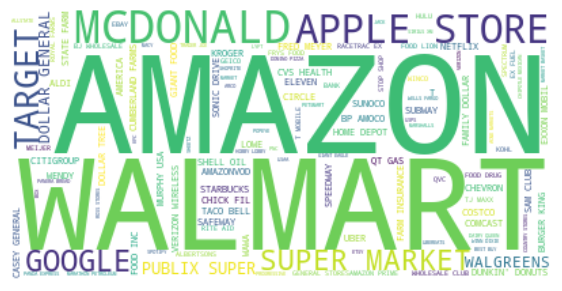

In [14]:
# Copy of the afs merchant names column
df_known_merchs['AFS_PAYMENT_AGENTS'] = df_known_merchs['payment_agent'] 
# Copy of the afs merchant names column
df_known_merchs['AFS_MECHANT_NAMES'] = df_known_merchs['merchant_name']
# Droping original cols
df_known_merchs = df_known_merchs.drop(['txn_desc1', 'txn_desc2','payment_agent','merchant_name'], axis=1)

# Word cloud for more frequent merchant names
word_cloud(df_known_merchs.AFS_MECHANT_NAMES)

In [15]:
df_known_merchs

,transaction_id,TRANSACTION_DETAILS,AFS_PAYMENT_AGENTS,AFS_MECHANT_NAMES
797966,Tc9136db5a389357d9786eacfd5479187,Point Of Sale Withdrawal %%%%% MCDONALD'S F21664 4215 LAS VEGAS NORTH LAS VEGAS NVUS,Unknow Payment Agent,MCDONALD'S
178055,Tfe2bfc76b3df3ad3be1e426be910812e,Withdrawal THE HOME DEPOT #4103 %%%%% BENSALEM PA %% Card 30 #9725 #**,Unknow Payment Agent,HOME DEPOT
71733,T90fba3e6fdca3b06a16246bef152061a,Withdrawal Debit Card %%%%% McDonald's 11075 148-*0 AZ Date 06/17/22 ***75851 5814,Unknow Payment Agent,MCDONALD'S
716799,T4bb396935c5c3860b30c9a7fd29ca4b6,Withdrawal MCSIGNATURE %%%%% DOORDASH*WENDYS SAN FRANCISCO CA Date 07/30/22 ***30505 5812 %% Card 19 #0074,DOORDASH,WENDY'S
998886,Ta621adab89f1356aac2a52a4951f93fe,DBT PURCHASE ON 06/01 @ 17:39 %%%%% JERSEY MIKES ONLINE OR 732-223-4044 NJ CARD NBR: -1347,Unknow Payment Agent,JERSEY MIKE'S SUBS
...,...,...,...,...
284941,Taca6f65e798b33e3b693177f4812bc30,Point Of Sale Withdrawal WWW %%%%% COSTCO COM 800-955-2292 WAUS,Unknow Payment Agent,COSTCO
423486,T6a69722b3ced35ba9d7efa9346df8833,WITHDRAWAL %%%%% POS 1205 1921 * DOLLAR GENERAL # COLUMBUS GA,Unknow Payment Agent,DOLLAR GENERAL
910221,T6defdfcf7a8930ba89f61c78781043d7,Withdrawal Debit TARGET.COM * %%%%% 800-591-3869 MNUS,Unknow Payment Agent,TARGET
191915,T8dd84a81e2623ee9b4167aa41804fc02,Withdrawal PFCU Check Card %%%%% UBER TRIP *8996 CA Date 02/22/23 ***76729 4121 %% Card 30 #1571,Unknow Payment Agent,UBER


In [16]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

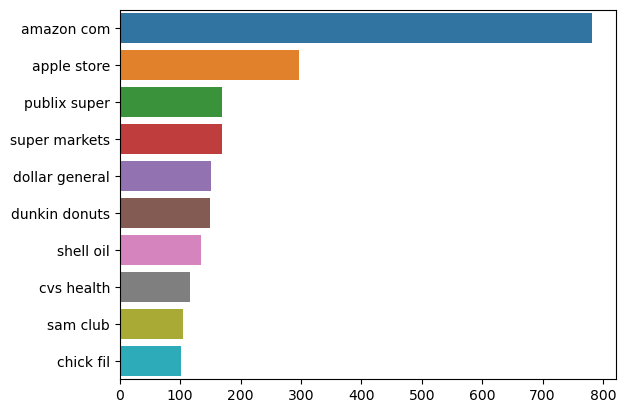

In [17]:
top_n_bigrams=get_top_ngram(df_known_merchs['AFS_MECHANT_NAMES'],2)[:10] 
x,y=map(list,zip(*top_n_bigrams)) 
sns.barplot(x=y,y=x);

In [18]:
def check_names(merchant, t_details):
    
    # Variations for merchant name column
    merchant_1 = merchant
    merchant_2 = merchant_1.lower()
    merchant_3 = re.sub("[\\\\/:*?'#<>|-]", '', merchant_2)
    merchant_4 = re.sub(' ', '', merchant_2)
    merchant_5 = re.sub('[.com/]', ' ', merchant_2)
    merch_list = merchant_1.split() + merchant_2.split() + merchant_3.split() + merchant_4.split() + merchant_5.split() + merchant.split()
    
    # Variations for transaction details column
    t_details_1 = t_details
    t_details_2 = t_details.lower()
    t_details_3 = re.sub("[\\\\/:*?'#<>|-]", '', t_details_2)
    t_details_4 = re.sub("[.com/]", " ",t_details_2)
    t_details_5 = re.sub("[\\\\/:*?'#<>|-]", ' ', t_details_2)
    
    # Merchants mentioned in transaction description w/ variations
    comp_1 = re.sub("Prime", "AMAZONVOD",t_details_1)
    comp_2 = re.sub("VZWRLSS", "VERIZON WIRELESS",t_details_1)
    comp_3 = re.sub("WM", "WALMART",t_details_1)
    
    # Creating a list of conversions to check if merchants are mentioned in transation descriotions 
    details_lis = t_details_2.split()
    details_lis_1 = t_details_1.split() + t_details_2.split() + t_details_3.split() + details_lis + t_details_4.split() + t_details_5.split() + comp_1.split() + comp_2.split() + comp_3.split() + t_details.split()
    
    # Conditions to check if words are in transaction strings
    if (merchant in t_details_3 or t_details_3 in merchant or 
        (merchant_2 in t_details_3 or t_details_3 in merchant_2) or 
        (merchant_3 in t_details_3 or t_details_3 in merchant_3) or
        (merchant_4 in t_details_3 or t_details_3 in merchant_4) or
        (merchant_1 in t_details_3 or t_details_1 in merchant_4) or
        (merchant_1 in details_lis_1 or merchant_4 in details_lis)or
        (any(item in merch_list for item in details_lis_1)) or
        (merchant_1[:4] in t_details_1)):
        return True
    else:
        return False
    

- Checked the occurrence of merchants in the first and secod transation colums separately
- Checked the total number of occurrences per column

In [19]:
# Merchants in the txt_1 or txt_2 columns
df_known_merchs_cp2['txn_desc2'] = df_known_merchs_cp2['txn_desc2'].astype(str)
df_known_merchs_cp2['txn_desc1'] = df_known_merchs_cp2['txn_desc1'].astype(str)
df_known_merchs_cp2['merchant_name'] = df_known_merchs_cp2['merchant_name'].astype(str)
df_known_merchs_cp2['CHECK_MERCH_TRA_cp'] = df_known_merchs_cp2.apply(lambda x: check_names(x.merchant_name, x.txn_desc1), axis=1) # OR txn_desc2
df_known_merchs_cp2.head(5)

,transaction_id,txn_desc1,txn_desc2,payment_agent,merchant_name,CHECK_MERCH_TRA_cp
797966,Tc9136db5a389357d9786eacfd5479187,Point Of Sale Withdrawal,MCDONALD'S F21664 4215 LAS VEGAS NORTH LAS VEGAS NVUS,Unknow Payment Agent,MCDONALD'S,False
178055,Tfe2bfc76b3df3ad3be1e426be910812e,Withdrawal THE HOME DEPOT #4103,BENSALEM PA %% Card 30 #9725 #**,Unknow Payment Agent,HOME DEPOT,True
71733,T90fba3e6fdca3b06a16246bef152061a,Withdrawal Debit Card,McDonald's 11075 148-*0 AZ Date 06/17/22 ***75851 5814,Unknow Payment Agent,MCDONALD'S,False
716799,T4bb396935c5c3860b30c9a7fd29ca4b6,Withdrawal MCSIGNATURE,DOORDASH*WENDYS SAN FRANCISCO CA Date 07/30/22 ***30505 5812 %% Card 19 #0074,DOORDASH,WENDY'S,False
998886,Ta621adab89f1356aac2a52a4951f93fe,DBT PURCHASE ON 06/01 @ 17:39,JERSEY MIKES ONLINE OR 732-223-4044 NJ CARD NBR: -1347,Unknow Payment Agent,JERSEY MIKE'S SUBS,False


In [20]:
print('Total of transactions with known merchants:\n',len(df_known_merchs_cp2))

Total of transactions with known merchants:
 10000


In [21]:
print('Merchant name occurrence in txn_desc1 column:\n',(df_known_merchs_cp2['CHECK_MERCH_TRA_cp'] == True).sum())

Merchant name occurrence in txn_desc1 column:
 4200


In [22]:
df_known_merchs_cp2['CHECK_MERCH_TRA_cp'] = df_known_merchs_cp2.apply(lambda x: check_names(x.merchant_name, x.txn_desc2), axis=1)
print('Merchant name occurrence in txn_desc2 column:\n',(df_known_merchs_cp2['CHECK_MERCH_TRA_cp'] == True).sum())

Merchant name occurrence in txn_desc2 column:
 7023


- Checked occurrence of merchants in concatenated transaction column
- Created CHECK_MERCH_TRA to inspect occurrences
- Checked total number of occurences in merchant details coolumn

In [23]:
# Checking if merchant names are mentioned in the transaction description
df_known_merchs['CHECK_MERCH_TRA'] = df_known_merchs.apply(lambda x: check_names(x.AFS_MECHANT_NAMES, x.TRANSACTION_DETAILS), axis=1)
df_known_merchs.head(5)

,transaction_id,TRANSACTION_DETAILS,AFS_PAYMENT_AGENTS,AFS_MECHANT_NAMES,CHECK_MERCH_TRA
797966,Tc9136db5a389357d9786eacfd5479187,Point Of Sale Withdrawal %%%%% MCDONALD'S F21664 4215 LAS VEGAS NORTH LAS VEGAS NVUS,Unknow Payment Agent,MCDONALD'S,True
178055,Tfe2bfc76b3df3ad3be1e426be910812e,Withdrawal THE HOME DEPOT #4103 %%%%% BENSALEM PA %% Card 30 #9725 #**,Unknow Payment Agent,HOME DEPOT,True
71733,T90fba3e6fdca3b06a16246bef152061a,Withdrawal Debit Card %%%%% McDonald's 11075 148-*0 AZ Date 06/17/22 ***75851 5814,Unknow Payment Agent,MCDONALD'S,True
716799,T4bb396935c5c3860b30c9a7fd29ca4b6,Withdrawal MCSIGNATURE %%%%% DOORDASH*WENDYS SAN FRANCISCO CA Date 07/30/22 ***30505 5812 %% Card 19 #0074,DOORDASH,WENDY'S,True
998886,Ta621adab89f1356aac2a52a4951f93fe,DBT PURCHASE ON 06/01 @ 17:39 %%%%% JERSEY MIKES ONLINE OR 732-223-4044 NJ CARD NBR: -1347,Unknow Payment Agent,JERSEY MIKE'S SUBS,True


In [24]:
# Merchant name in the transaction description
print('Merchant name in the transaction description:\n',(df_known_merchs['CHECK_MERCH_TRA'] == True).sum() )

Merchant name in the transaction description:
 9848


- Created a copy to encode CHECK_MERCH_TRA results
- Created a chart to compare the results
- Created a word cloud of AFS_MECHANT_NAMES to get most frequen merchants
- Checked how many times merchants are mentioned in transaction details
- Checked how many times merchants are not in transaction details
- Created word cloud for merchants not in transaction details 

In [25]:
df_known_merchs_cp = df_known_merchs[['transaction_id','TRANSACTION_DETAILS','AFS_PAYMENT_AGENTS','AFS_MECHANT_NAMES','CHECK_MERCH_TRA']].copy(deep=True)
df_known_merchs_cp.head()

,transaction_id,TRANSACTION_DETAILS,AFS_PAYMENT_AGENTS,AFS_MECHANT_NAMES,CHECK_MERCH_TRA
797966,Tc9136db5a389357d9786eacfd5479187,Point Of Sale Withdrawal %%%%% MCDONALD'S F21664 4215 LAS VEGAS NORTH LAS VEGAS NVUS,Unknow Payment Agent,MCDONALD'S,True
178055,Tfe2bfc76b3df3ad3be1e426be910812e,Withdrawal THE HOME DEPOT #4103 %%%%% BENSALEM PA %% Card 30 #9725 #**,Unknow Payment Agent,HOME DEPOT,True
71733,T90fba3e6fdca3b06a16246bef152061a,Withdrawal Debit Card %%%%% McDonald's 11075 148-*0 AZ Date 06/17/22 ***75851 5814,Unknow Payment Agent,MCDONALD'S,True
716799,T4bb396935c5c3860b30c9a7fd29ca4b6,Withdrawal MCSIGNATURE %%%%% DOORDASH*WENDYS SAN FRANCISCO CA Date 07/30/22 ***30505 5812 %% Card 19 #0074,DOORDASH,WENDY'S,True
998886,Ta621adab89f1356aac2a52a4951f93fe,DBT PURCHASE ON 06/01 @ 17:39 %%%%% JERSEY MIKES ONLINE OR 732-223-4044 NJ CARD NBR: -1347,Unknow Payment Agent,JERSEY MIKE'S SUBS,True


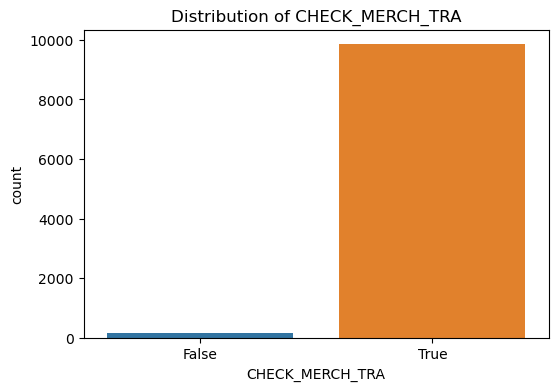

In [26]:
plt.figure(figsize=(6, 4))
sns.countplot(x="CHECK_MERCH_TRA", data=df_known_merchs_cp)
plt.title("Distribution of CHECK_MERCH_TRA");

In [27]:
print('Percentage of merchant names in T details or not (1/0):\n',(df_known_merchs_cp.CHECK_MERCH_TRA).value_counts(normalize=True).mul(100).round(1).astype(str) + '%');

Percentage of merchant names in T details or not (1/0):
 True     98.5%
False     1.5%
Name: CHECK_MERCH_TRA, dtype: object


In [28]:
# Number of merchant names in transaction details
df_check_true = pd.DataFrame()
df_check_true = df_known_merchs.loc[df_known_merchs['CHECK_MERCH_TRA'] == True]
print('Number of merchant names in transaction details:\n',len(df_check_true))

Number of merchant names in transaction details:
 9848


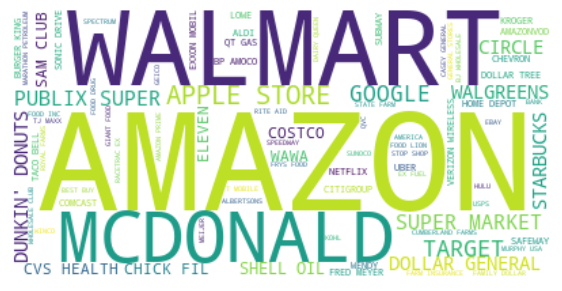

In [29]:
# Word cloud for more frequent merchant names WHEN merchant name is in transaction description

word_cloud(df_check_true.AFS_MECHANT_NAMES)

In [30]:
print('Total number of occurences per merchant name:\n',(df_check_true.AFS_MECHANT_NAMES).value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

Total number of occurences per merchant name:
 AMAZON.COM     7.8%
WALMART        7.0%
MCDONALD'S     3.6%
APPLE STORE    3.0%
TARGET         2.3%
               ... 
TROPICANA      0.0%
EQUIFAX        0.0%
ULINE          0.0%
HESS           0.0%
HOME CHEF      0.0%
Name: AFS_MECHANT_NAMES, Length: 692, dtype: object


In [31]:
print('Number of merchant names NOT in the transaction description:\n',(df_known_merchs['CHECK_MERCH_TRA'] == False).sum())

Number of merchant names NOT in the transaction description:
 152


In [32]:
# Number of merchant names not in transaction details
df_check_false = pd.DataFrame()
df_check_false = df_known_merchs.loc[df_known_merchs['CHECK_MERCH_TRA'] == False]
#print('Number of merchant names NOT in the transaction description:\n', len(df_check_false))

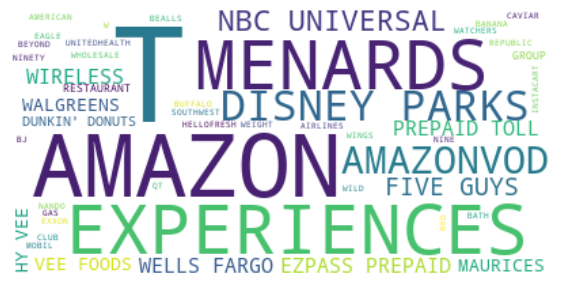

In [33]:
# Word cloud for more frequent merchant names WHEN merchant name is NOT in transaction description
word_cloud(df_check_false.AFS_MECHANT_NAMES)

In [34]:
print('Total number of occurences per merchant name WHEN merchant name is NOT in transation details:\n', (df_check_false.AFS_MECHANT_NAMES).value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

Total number of occurences per merchant name WHEN merchant name is NOT in transation details:
 AT&T                            33.6%
AMAZON.COM                      11.2%
MENARDS                          6.6%
DISNEY PARKS AND EXPERIENCES     6.6%
AMAZONVOD                        5.9%
NBC UNIVERSAL                    5.3%
FIVE GUYS                        3.9%
AT&T WIRELESS                    2.6%
EZPASS PREPAID TOLL              2.6%
WELLS FARGO                      2.6%
MAURICES                         2.0%
HY-VEE-FOODS                     2.0%
WALGREENS                        2.0%
DUNKIN' DONUTS                   2.0%
NANDO'S RESTAURANT GROUP         0.7%
BED BATH & BEYOND                0.7%
EXXON MOBIL                      0.7%
SOUTHWEST AIRLINES               0.7%
UNITEDHEALTH GROUP               0.7%
BUFFALO WILD WINGS               0.7%
AMERICAN EAGLE                   0.7%
QT GAS                           0.7%
BANANA REPUBLIC                  0.7%
INSTACART                      

- Merchant names not mentioned in transaction description

In [35]:
# Merchant names not mentioned in transaction description
df_known_merchs.loc[df_known_merchs['CHECK_MERCH_TRA']==False] 


,transaction_id,TRANSACTION_DETAILS,AFS_PAYMENT_AGENTS,AFS_MECHANT_NAMES,CHECK_MERCH_TRA
1437964,T019c6ad4567633a48ea235ccf268ba1a,XX3934 POS WITHDRAWAL. HY VEE 1888 WEST DES MOIN IA 1 * %%%%% nan,Unknow Payment Agent,HY-VEE-FOODS,False
320494,T9c9e5f07faa7329084301109909041da,POS Transaction %%%%% MARCS NILES NILES OHUS,Unknow Payment Agent,MAURICES,False
895279,T4ef2706c6ece32edb4dd905fc4bb3632,DEBIT CARD DEBIT %%%%% auth #46743 12-19-2022 DD/BR #* 856-577-1106 IN Eff. Date: *,Unknow Payment Agent,DUNKIN' DONUTS,False
437920,T1f39ef0e092c37a386e6c90daa3d1e67,Card purchase %%%%% ATT* BILL PAYMENT 4814 (2022-07-26) 800-331-0500 TX 0001,Unknow Payment Agent,AT&T,False
619026,Tf5ef891064b03724827666d6d6e3f2b8,External Withdrawal ATT - %%%%% Payment,Unknow Payment Agent,AT&T,False
...,...,...,...,...,...
289213,Tf6a6c237c0e431828527de68e55ac90e,ATT - Payment %%%%% ACH Withdrawal,Unknow Payment Agent,AT&T,False
30218,T389d3581370d3ad7bacb539f486f6b1a,WITHDRAW %%%%% WF HOME MTG AUTO PAY *,Unknow Payment Agent,WELLS FARGO,False
673700,T2539f5a2e490341d81e6b16f9e6ea4c6,DEBIT CARD DEBIT %%%%% 12-29-2022 PRIME VIDEO *IY5P55 auth #17253 Eff. Date: **,Unknow Payment Agent,AMAZONVOD,False
926999,T5f23d49f0d5837c99d6d7079d5bd575a,ATT - Payment %%%%% ACH Withdrawal,Unknow Payment Agent,AT&T,False


# Named Entity Recognition
- Created a copy of df_known_merchs for predictions purposes - "df_known_merchs_pred"
- Created the PREDICTIONS column
- Used NER from Spacy
- Applied Entity Ruler to add all the merchants (PATTERNS) from AFS into the model
- Defined function to find patterns from AFS predictions - "def_patterns"
- Defined function to find the organisations in the Transaction details column - "find_org"
- Defined funtion to implement parallel processing = "find_org_parallel"
- Implemented cust NER model and displayed the results

In [36]:
df_known_merchs_pred = df_known_merchs.copy(deep=True)
df_known_merchs_pred['AFS_MECHANT_NAMES'] = df_known_merchs_pred['AFS_MECHANT_NAMES'].str.lower()
df_known_merchs_pred['TRANSACTION_DETAILS']= df_known_merchs_pred['TRANSACTION_DETAILS'].str.lower().str.replace(r'\s{2,}','').str.replace(r"[,;@#?!&$*]+\ *", " ")

In [37]:
df_known_merchs_pred.head(10)

,transaction_id,TRANSACTION_DETAILS,AFS_PAYMENT_AGENTS,AFS_MECHANT_NAMES,CHECK_MERCH_TRA
797966,Tc9136db5a389357d9786eacfd5479187,point of sale withdrawal %%%%% mcdonald's f21664 4215 las vegas north las vegas nvus,Unknow Payment Agent,mcdonald's,True
178055,Tfe2bfc76b3df3ad3be1e426be910812e,withdrawal the home depot 4103 %%%%% bensalem pa %% card 30 9725,Unknow Payment Agent,home depot,True
71733,T90fba3e6fdca3b06a16246bef152061a,withdrawal debit card %%%%% mcdonald's 11075 148- 0 az date 06/17/22 75851 5814,Unknow Payment Agent,mcdonald's,True
716799,T4bb396935c5c3860b30c9a7fd29ca4b6,withdrawal mcsignature %%%%% doordash wendys san francisco ca date 07/30/22 30505 5812 %% card 19 0074,DOORDASH,wendy's,True
998886,Ta621adab89f1356aac2a52a4951f93fe,dbt purchase on 06/01 17:39 %%%%% jersey mikes online or 732-223-4044 nj card nbr: -1347,Unknow Payment Agent,jersey mike's subs,True
759743,T292a6fd3c55536af850606f81a268c95,ach withdrawal %%%%% company:kohl's chg pymt id: 747,Unknow Payment Agent,kohl's,True
805677,T1abe5518403b346a9c75aabef5506a97,withdrawal %%%%% wal wal-mart super 1549 wal-sams phoenix (w) az,Unknow Payment Agent,walmart,True
1387471,T81f4cea8584330d282456a7720739e45,pos purchase on 01/27 17:52 %%%%% lowe's 0026 2701 s orchard street tacoma wa card nbr: -6215,Unknow Payment Agent,lowe's,True
27978,T1dbe0eab1d9236e9a6ec1062ec5e0ad5,pos transaction %%%%% love's 608 mcpherson ksus,Unknow Payment Agent,loves travel & country stores,True
871711,T3ee7b80bcd483af58a931ace6d43ba2a,withdrawal consumer debit %%%%% circle k 03702 clarksville tn date 07/07/22 0 3341 0 5541 %% card 18 6432,Unknow Payment Agent,circle k,True


- Function to find and create a list of patterns

In [38]:
def def_patterns(a):

    #Creating a list of patterns - with all the merchant names (with and without spaces, quotes, .com, etc.)

    org =  a #df_known_payment_agents['AFS_MECHANT_NAMES']

    #List of Entities and Patterns
    org_list = org.tolist()

    a = [ x.strip() for x in org_list] # list comprehension - all merchant names from original org_list
    a_space =list(filter(lambda x: ' ' in x, a)) # filtering all names w spaces
    a_nospace = [x.replace(' ', '') for x in a_space] # replacing spaces w ''

    a_quo =list(filter(lambda x: "'" in x, a)) # filtering all names w quotes
    a_noquuo = [x.replace("'", '') for x in a_quo] # replacing quotes w ''

    a_com =list(filter(lambda x: '.com' in x, a)) # filtering all names w .com
    a_nocom = [x.replace('.com', '') for x in a_com] # replacing .com w ''

    a_dash =list(filter(lambda x: '-' in x, a)) # filtering all names w dash
    a_nodash = [x.replace('-', '') for x in a_com] # replacing dash w ''

    new_lis = a + a_nospace + a_nocom + a_noquuo + a_nodash # add instead of dis_list


    # Creating a list of patterns with all the variations from new_lis
    patterns = []
    i = 0
    new_lis = tuple(new_lis)
    for item in new_lis:
        patterns.append({"label": 'ORG', "pattern": [{"LOWER":item}]})
        # patterns.append({"label": 'ORG', "pattern": new_lis[i]})
        i+=1

    # #print(patterns)
    #patterns.append(listb)
    #print(patterns)


    return patterns

In [39]:
patterns = def_patterns(df_known_merchs_pred['AFS_MECHANT_NAMES'])

- Function to find organisations using patterns

In [40]:
# Function to find merchant names in a string - using an NER model with the previously created patterns

def find_org(text:str):
    
    #Build upon the spaCy Model
    NER2 = spacy.load("en_core_web_sm")
    
    #Create the EntityRuler
    ruler = NER2.add_pipe("entity_ruler", config={'validate': True})
     
    ruler.add_patterns(patterns)
    doc_ner = NER2(text)
    
    # useless strings
    junk = ['fip', 'ca(2810','fis','xx4386', '#185','*','hr0d','k50ms3hv','xx9510','xx4710','xx4706','xx0322','he34i8pz0','xx3840','pd1387','ma(9661','ns4qa9xb3 ']
    
    #extract entities
    orgs = []
    for ent in doc_ner.ents:
        if ((ent.label_ == "ORG") and (ent.text not in junk)):
            orgs.append(ent.text)
    orgs = list(set(orgs))
    return ' '.join(orgs) if orgs else 'NA'

- Function for parallel processing

In [41]:
def find_org_parallel(a:dict):
    i=a.copy()
    print(i)
    result = find_org(i['TRANSACTION_DETAILS'])
    i['PREDICTIONS']= result
    print(i)
    return i

In [42]:
df_known_merchs_pred.head(5)

,transaction_id,TRANSACTION_DETAILS,AFS_PAYMENT_AGENTS,AFS_MECHANT_NAMES,CHECK_MERCH_TRA
797966,Tc9136db5a389357d9786eacfd5479187,point of sale withdrawal %%%%% mcdonald's f21664 4215 las vegas north las vegas nvus,Unknow Payment Agent,mcdonald's,True
178055,Tfe2bfc76b3df3ad3be1e426be910812e,withdrawal the home depot 4103 %%%%% bensalem pa %% card 30 9725,Unknow Payment Agent,home depot,True
71733,T90fba3e6fdca3b06a16246bef152061a,withdrawal debit card %%%%% mcdonald's 11075 148- 0 az date 06/17/22 75851 5814,Unknow Payment Agent,mcdonald's,True
716799,T4bb396935c5c3860b30c9a7fd29ca4b6,withdrawal mcsignature %%%%% doordash wendys san francisco ca date 07/30/22 30505 5812 %% card 19 0074,DOORDASH,wendy's,True
998886,Ta621adab89f1356aac2a52a4951f93fe,dbt purchase on 06/01 17:39 %%%%% jersey mikes online or 732-223-4044 nj card nbr: -1347,Unknow Payment Agent,jersey mike's subs,True


In [43]:
t_list = df_known_merchs_pred[['transaction_id', 'TRANSACTION_DETAILS', 'AFS_MECHANT_NAMES', 'CHECK_MERCH_TRA']].copy(deep=True).to_dict(orient='records') #replace similarity w unique ID

In [44]:
# df_known_merchs_pred['PREDICTIONS'] = df_known_merchs_pred.TRANSACTION_DETAILS.swifter.apply(find_org)

In [45]:
par = Parallel(n_jobs=-1)(delayed(find_org_parallel)(i) for i in tqdm(t_list))

100%|██████████| 10000/10000 [1:14:17<00:00,  2.24it/s]


In [46]:
df_known_merchs_pred = pd.DataFrame(par)

- Function to compare results - True/False

In [47]:
def check_names_pred(a, b):
    if ((a in b) or (b in a)):
        return True
    elif (fuzz.ratio(a, b) > 92):
        return True
    else:
        return False

- NER predictions using Spacy and Entity Ruler technique

In [48]:
df_known_merchs_pred['CHECK_TF'] = df_known_merchs_pred.apply(lambda x: check_names(x.AFS_MECHANT_NAMES, x.PREDICTIONS), axis=1)
df_known_merchs_pred.sample(10)

,transaction_id,TRANSACTION_DETAILS,AFS_MECHANT_NAMES,CHECK_MERCH_TRA,PREDICTIONS,CHECK_TF
6271,T7051d2b596c63ea59f29649d5dd3d6cb,publix 14375 miramar %%%%% pkwy miramar flus : pos transaction,publix super markets,True,NA,False
1606,T4f5f9a5b337d37ad82fe57b1fc3ccaf4,withdrawal debit dollar ge dg %%%%% 233 zellwood flus,dollar general,True,NA,False
7280,T101883d33f2e3b17ae2a5064b7b0bd7e,pos withdrawal (fip) market %%%%% basket 8 24 will s can blvd fall river ma(7937),market basket,True,NA,False
6688,Td61bd52005e93369a1b827e628a73d70,pos withdrawal (fip) nnt ocean %%%%% state 465 william s. cann fall river ma(3758),ocean state job lot,True,NA,False
4294,Tb8b153373dfc36a2a7cd5c580cf2e2dd,withdrawal consumer debit %%%%% ocharleys236wlmarud clarksville tn date 03/01/23 0 1055 0 5812 %% card 18 7068,o'charley's,True,NA,False
488,T3b4601b4715b3f2bbe2d0ac7755f0f10,withdrawal debit card %%%%% amazon music 1h6bu84w1 440 terry ave n 888 date 03/30/22 3 259 5 5818 %% card 15 4714 %% mcc 5818,amazon.com,True,amazon,True
1884,T2e04b2e8a15e3cf19d67417fc376d82f,withdrawal debit publix 1381 %%%%% winter park flus,publix super markets,True,NA,False
1491,Tfda1f6ae89b532c8830ac13d470608a5,withdrawal debit panda express %%%%% 347 deland flus,panda express,True,NA,False
9219,Te8b52aace8cc35b7b1cf275e1fd6bf12,fee %%%%% pos 0525 2031 winco foods 69 fresno ca atm transaction fee 0.75,winco,True,winco foods,True
5629,Teb76d70abdd63ff5969b9a58e4b0e2f7,withdrawal %%%%% chevron/bro stations l peoria az,chevron,True,chevron,True


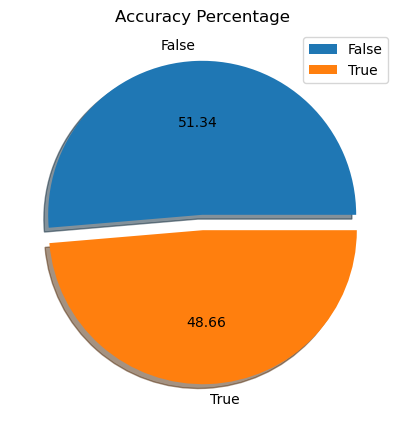

In [49]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 5))
df_known_merchs_pred.groupby('CHECK_TF').size().plot(kind='pie', autopct='%.2f', title='Accuracy Percentage', explode=[0.05, 0.05], legend=True, shadow=True)
ax1.set_ylabel('', size=10);


In [50]:
(df_known_merchs_pred.CHECK_TF).value_counts()

False    5134
True     4866
Name: CHECK_TF, dtype: int64

# ML Models - Labelling
- Created different classification models for labelling
    - Multinomial Naive Bayes
    - Linear SVC
    - K-Nearest Neighbors

In [51]:
df_known_class_pred = df_known_merchs[['transaction_id','TRANSACTION_DETAILS','AFS_MECHANT_NAMES']].copy(deep=True)
df_known_class_pred['AFS_MECHANT_NAMES'] = df_known_class_pred['AFS_MECHANT_NAMES'].str.lower()
df_known_class_pred['TRANSACTION_DETAILS']= df_known_class_pred['TRANSACTION_DETAILS'].str.lower().str.replace(r'\s{2,}','').str.replace(r"[,;@#?!&$*]+\ *", " ")

In [52]:
df_known_class_pred.head(10)

,transaction_id,TRANSACTION_DETAILS,AFS_MECHANT_NAMES
797966,Tc9136db5a389357d9786eacfd5479187,point of sale withdrawal %%%%% mcdonald's f21664 4215 las vegas north las vegas nvus,mcdonald's
178055,Tfe2bfc76b3df3ad3be1e426be910812e,withdrawal the home depot 4103 %%%%% bensalem pa %% card 30 9725,home depot
71733,T90fba3e6fdca3b06a16246bef152061a,withdrawal debit card %%%%% mcdonald's 11075 148- 0 az date 06/17/22 75851 5814,mcdonald's
716799,T4bb396935c5c3860b30c9a7fd29ca4b6,withdrawal mcsignature %%%%% doordash wendys san francisco ca date 07/30/22 30505 5812 %% card 19 0074,wendy's
998886,Ta621adab89f1356aac2a52a4951f93fe,dbt purchase on 06/01 17:39 %%%%% jersey mikes online or 732-223-4044 nj card nbr: -1347,jersey mike's subs
759743,T292a6fd3c55536af850606f81a268c95,ach withdrawal %%%%% company:kohl's chg pymt id: 747,kohl's
805677,T1abe5518403b346a9c75aabef5506a97,withdrawal %%%%% wal wal-mart super 1549 wal-sams phoenix (w) az,walmart
1387471,T81f4cea8584330d282456a7720739e45,pos purchase on 01/27 17:52 %%%%% lowe's 0026 2701 s orchard street tacoma wa card nbr: -6215,lowe's
27978,T1dbe0eab1d9236e9a6ec1062ec5e0ad5,pos transaction %%%%% love's 608 mcpherson ksus,loves travel & country stores
871711,T3ee7b80bcd483af58a931ace6d43ba2a,withdrawal consumer debit %%%%% circle k 03702 clarksville tn date 07/07/22 0 3341 0 5541 %% card 18 6432,circle k


In [53]:
import io

In [54]:
def df_description(clss, a_test,a_pred,a_train,b_train,b_test):     
    #(classifier, y_test, y_pred, y_train,X_train,X_test)
    
    print('Accuracy : {0:0.3f}'.format(accuracy_score(a_test, a_pred)))
    
    #----------
    print('Number of unique merchants in the test set: ', len(a_test.unique()))
    print('Number of unique merchants in the predicted set: ', len(np.unique(a_pred)))
    print('Number of unique merchants in train set: ', len(a_train.unique()))
    print('\nNumber of unique "Transaction Details" rows in test set: ', len(b_train.unique()))
    print('Number of unique "Transaction Details" rows in train set: ', len(b_test.unique()))
    print('\nTotal number of rows in the train set: ', len(b_train))
    print('Total number of rows in the test set', len(b_test))
    
    
    train_acc = accuracy_score(a_train, clss.predict(b_train))
    test_acc = accuracy_score(a_test, a_pred)
    print("Train accuracy:", train_acc)
    print("Test accuracy:", test_acc)
    
    #============================================================
    
    # Get the classification report as a string
    report_dict = metrics.classification_report(a_test, a_pred, zero_division=0, output_dict=True)

    # Convert the report dictionary to a pandas dataframe
    report_data = pd.DataFrame(report_dict).transpose()
    
    precision_count = (report_data['precision'] == 1).sum()
    total_categories = report_data.shape[0]
    precision_percentage = precision_count / total_categories * 100
    
    print('\n===================================\n')
    print('Percentage of best precision', precision_percentage)
    
    recall_count = (report_data['recall'] == 1).sum()
    total_categories = report_data.shape[0]
    recall_percentage = recall_count / total_categories * 100
    print('===================================\n')
    print('Percentage of best recall', recall_percentage)
    
    f1score_count = (report_data['f1-score'] == 1).sum()
    total_categories = report_data.shape[0]
    f1score_percentage = f1score_count / total_categories * 100
    print('===================================\n')
    print('Percentage of best f1score', f1score_percentage)
    
    print('===================================\n')
    
    return
    
    

In [55]:
def c_matrix(a_pred, a_test):

    # count the number of occurrences of each predicted label
    value_counts = Counter(a_pred)

    # sort the labels by descending order of count
    sorted_labels = sorted(value_counts, key=value_counts.get, reverse=True)

    # print the top 10 labels by count
    for label in sorted_labels[:10]:
        print(f"{label}: {value_counts[label]}")
    

    # get the indices of the top 10 predicted values
    top_10_labels = sorted_labels[:10]

    # filter the true and predicted labels to only include the top 10 labels
    top_10_true = [label if label in top_10_labels else "Other" for label in a_test]
    top_10_pred = [label if label in top_10_labels else "Other" for label in a_pred]

    # create the confusion matrix
    cm = confusion_matrix(top_10_true, top_10_pred)

    # plot the confusion matrix
    fig, ax = plt.subplots(figsize=(7, 7))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=top_10_labels, yticklabels=top_10_labels + ["Other"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
    
    #========================================================================================================================
    

    # sort the labels by ascending order of count
    sorted_labels2 = sorted(value_counts, key=value_counts.get, reverse=False)

    # print the 10 least predicted labels by count
    for label2 in sorted_labels2[:10]:
        print(f"{label2}: {value_counts[label2]}")
    

    # get the indices of the top 10 predicted values
    least_10_labels = sorted_labels2[:10]

    # filter the true and predicted labels to only include the top 10 labels
    least_10_true = [label2 if label2 in least_10_labels else "Other" for label2 in a_test]
    least_10_pred = [label2 if label2 in least_10_labels else "Other" for label2 in a_pred]

    # create the confusion matrix
    cm = confusion_matrix(least_10_true, least_10_pred)

    # plot the confusion matrix
    fig, ax = plt.subplots(figsize=(5, 4))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=least_10_labels, yticklabels=least_10_labels + ["Other"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
    return

In [56]:
def train(classifier, X, y):

    start = time.time()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)        
    
    # Random over-sampling due to imbalanced classes
    resampler = RandomOverSampler(random_state=0)
    X_train_oversampled, y_train_oversampled = resampler.fit_resample(X_train.to_numpy().reshape(-1, 1), y_train)
    #sns.countplot(x=y_train_oversampled)  
    
    classifier.fit(X_train_oversampled[:, 0], y_train_oversampled)                                                           
    end = time.time()                                                                                
    
    y_pred = classifier.predict(X_test) 
  
  
    df_description(classifier, y_test, y_pred, y_train,X_train,X_test)
    c_matrix(y_pred, y_test)
    
    print('\n\n', metrics.classification_report(y_test, y_pred))
    
    return classifier


In [57]:
df_known_class_pred

,transaction_id,TRANSACTION_DETAILS,AFS_MECHANT_NAMES
797966,Tc9136db5a389357d9786eacfd5479187,point of sale withdrawal %%%%% mcdonald's f21664 4215 las vegas north las vegas nvus,mcdonald's
178055,Tfe2bfc76b3df3ad3be1e426be910812e,withdrawal the home depot 4103 %%%%% bensalem pa %% card 30 9725,home depot
71733,T90fba3e6fdca3b06a16246bef152061a,withdrawal debit card %%%%% mcdonald's 11075 148- 0 az date 06/17/22 75851 5814,mcdonald's
716799,T4bb396935c5c3860b30c9a7fd29ca4b6,withdrawal mcsignature %%%%% doordash wendys san francisco ca date 07/30/22 30505 5812 %% card 19 0074,wendy's
998886,Ta621adab89f1356aac2a52a4951f93fe,dbt purchase on 06/01 17:39 %%%%% jersey mikes online or 732-223-4044 nj card nbr: -1347,jersey mike's subs
...,...,...,...
284941,Taca6f65e798b33e3b693177f4812bc30,point of sale withdrawal www %%%%% costco com 800-955-2292 waus,costco
423486,T6a69722b3ced35ba9d7efa9346df8833,withdrawal %%%%% pos 1205 1921 dollar general columbus ga,dollar general
910221,T6defdfcf7a8930ba89f61c78781043d7,withdrawal debit target.com %%%%% 800-591-3869 mnus,target
191915,T8dd84a81e2623ee9b4167aa41804fc02,withdrawal pfcu check card %%%%% uber trip 8996 ca date 02/22/23 76729 4121 %% card 30 1571,uber


- Multinomial Naive Bayes

Accuracy : 0.754
Number of unique merchants in the test set:  377
Number of unique merchants in the predicted set:  324
Number of unique merchants in train set:  640

Number of unique "Transaction Details" rows in test set:  7662
Number of unique "Transaction Details" rows in train set:  1976

Total number of rows in the train set:  8000
Total number of rows in the test set 2000
Train accuracy: 0.999
Test accuracy: 0.754


Percentage of best precision 26.25570776255708

Percentage of best recall 26.71232876712329

Percentage of best f1score 16.43835616438356

amazon.com: 151
walmart: 143
apple store: 59
mcdonald's: 57
publix super markets: 44
target: 40
google: 39
dollar general: 39
dunkin' donuts: 38
cvs health: 35


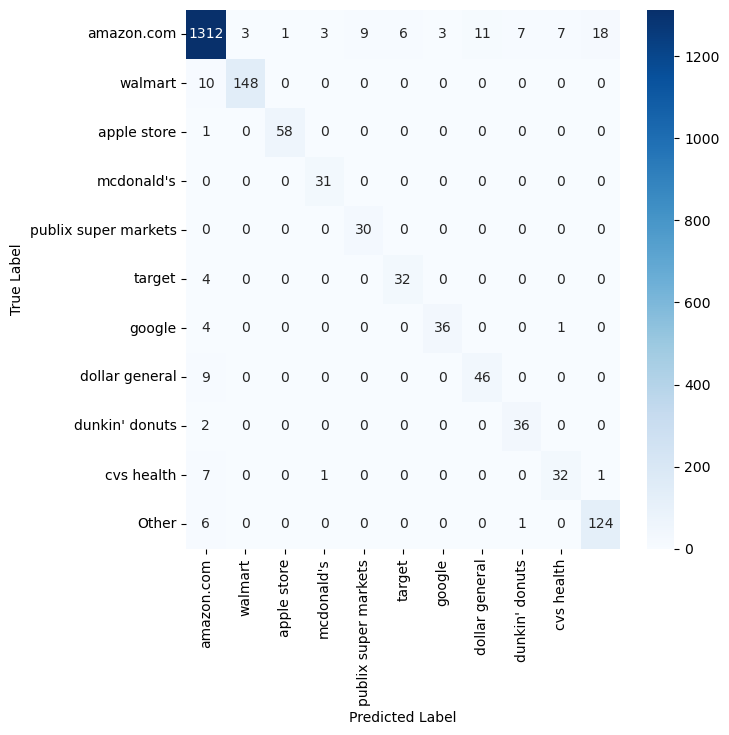

foot locker: 1
five below: 1
cato: 1
office depot: 1
build-a-bear workshop: 1
shutterfly: 1
phillips 66: 1
smart & final: 1
cracker barrel: 1
savemart supermarket: 1


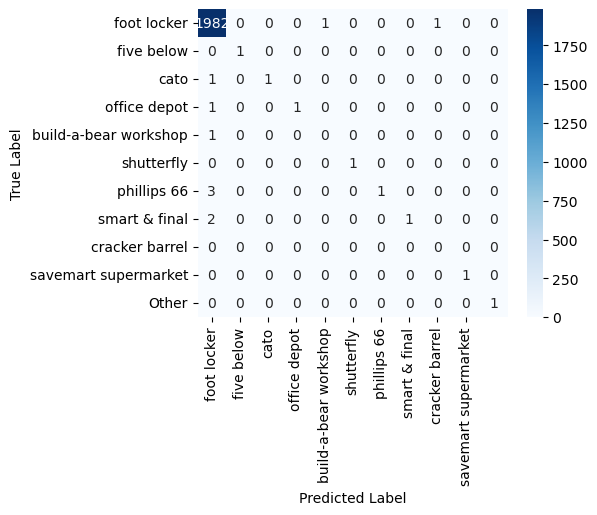



                                     precision    recall  f1-score   support

                     1-800-petmeds       0.00      0.00      0.00         1
                          7 eleven       0.87      0.87      0.87        23
                          abuelo's       0.00      0.00      0.00         0
         academy sports + outdoors       0.33      0.33      0.33         3
                      ace hardware       0.50      0.67      0.57         3
                      acme markets       0.80      0.89      0.84         9
                            adidas       0.00      0.00      0.00         1
                     adobe systems       1.00      0.33      0.50         3
             adt security services       1.00      1.00      1.00         3
                advance auto parts       1.00      1.00      1.00         1
                       aeropostale       0.00      0.00      0.00         1
                             aetna       0.00      0.00      0.00         0
        

c:\Users\Olimpio.Dasilva\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Olimpio.Dasilva\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Olimpio.Dasilva\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Olimpio.Dasilva\Anaconda

In [58]:
classifier1 = Pipeline([ ('vectorizer', TfidfVectorizer(stop_words=stopwords.words('english') + list(string.punctuation))),
                        ('classifier', MultinomialNB(alpha=0.005))])

train(classifier1, df_known_class_pred['TRANSACTION_DETAILS'], df_known_class_pred['AFS_MECHANT_NAMES'])

MNB = cls_acc
Mtime = cls_time
# print("\n\nMNB: ", MNB)
# print("Time: ", Mtime)



- Linear SVC

Accuracy : 0.939
Number of unique merchants in the test set:  377
Number of unique merchants in the predicted set:  337
Number of unique merchants in train set:  640

Number of unique "Transaction Details" rows in test set:  7662
Number of unique "Transaction Details" rows in train set:  1976

Total number of rows in the train set:  8000
Total number of rows in the test set 2000
Train accuracy: 0.999875
Test accuracy: 0.939


Percentage of best precision 59.22330097087378

Percentage of best recall 66.01941747572816

Percentage of best f1score 55.09708737864077

amazon.com: 158
walmart: 131
apple store: 59
mcdonald's: 55
google: 43
target: 41
publix super markets: 38
circle k: 37
dunkin' donuts: 37
cvs health: 32


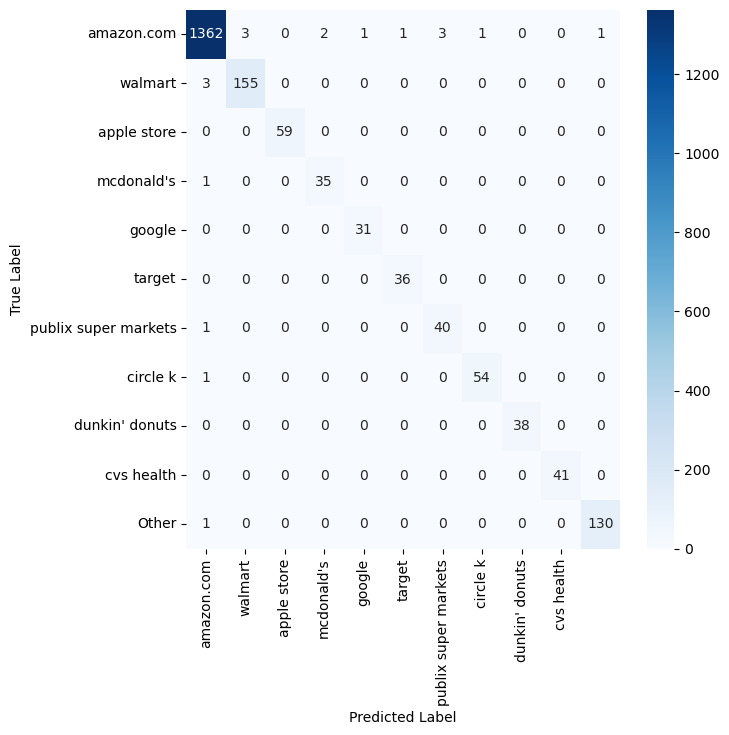

foot locker: 1
sears: 1
price chopper: 1
build-a-bear workshop: 1
shutterfly: 1
burlington coat factory: 1
boston market: 1
bojangles: 1
boost mobile: 1
o'reilly automotive: 1


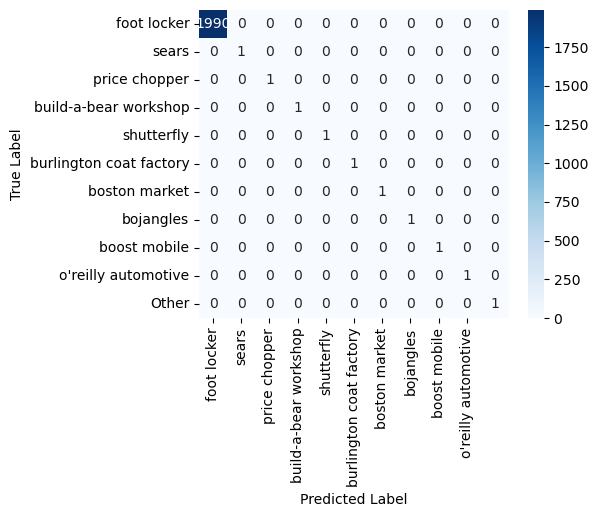



                                precision    recall  f1-score   support

                1-800-petmeds       0.00      0.00      0.00         1
              24 hour fitness       0.00      0.00      0.00         0
                     7 eleven       0.96      1.00      0.98        23
    academy sports + outdoors       0.75      1.00      0.86         3
                 ace hardware       1.00      1.00      1.00         3
                 acme markets       1.00      1.00      1.00         9
                       adidas       0.00      0.00      0.00         1
                adobe systems       1.00      0.67      0.80         3
        adt security services       1.00      1.00      1.00         3
           advance auto parts       1.00      1.00      1.00         1
                  aeropostale       0.00      0.00      0.00         1
                   albertsons       1.00      1.00      1.00         6
                         aldi       1.00      1.00      1.00        15
  

c:\Users\Olimpio.Dasilva\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Olimpio.Dasilva\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Olimpio.Dasilva\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Olimpio.Dasilva\Anaconda

In [59]:
from sklearn.svm import LinearSVC

classifier2 = Pipeline([('vectorizer', TfidfVectorizer(stop_words=stopwords.words('english') + list(string.punctuation))),
                        ('classifier', LinearSVC(C=10))])

train(classifier2, df_known_class_pred['TRANSACTION_DETAILS'], df_known_class_pred['AFS_MECHANT_NAMES'])

SVC = cls_acc
Stime = cls_time
# print("\n\nSVC: ", SVC)
# print("Time: ", Stime)


- K-Nearest Neighbors

Accuracy : 0.724
Number of unique merchants in the test set:  377
Number of unique merchants in the predicted set:  327
Number of unique merchants in train set:  640

Number of unique "Transaction Details" rows in test set:  7662
Number of unique "Transaction Details" rows in train set:  1976

Total number of rows in the train set:  8000
Total number of rows in the test set 2000
Train accuracy: 0.975875
Test accuracy: 0.7235


Percentage of best precision 30.373831775700932

Percentage of best recall 29.906542056074763

Percentage of best f1score 20.327102803738317

amazon.com: 146
walmart: 118
apple store: 59
dunkin' donuts: 56
target: 41
google: 39
publix super markets: 39
shell oil: 38
dollar general: 36
cvs health: 33


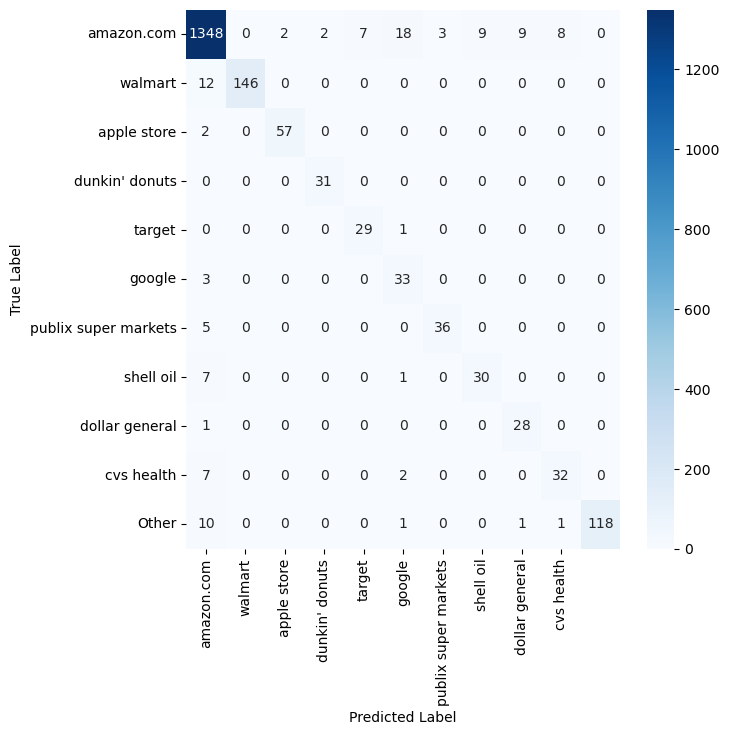

foot locker: 1
five below: 1
the fresh market: 1
price chopper: 1
cato: 1
build-a-bear workshop: 1
shutterfly: 1
boston market: 1
belk: 1
boost mobile: 1


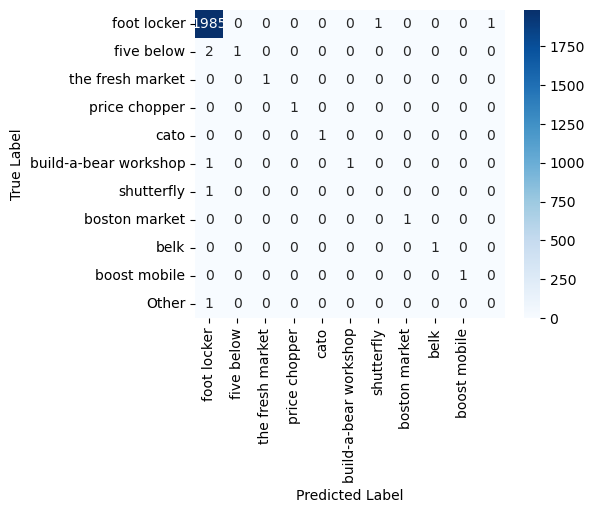



                                precision    recall  f1-score   support

                1-800-petmeds       0.00      0.00      0.00         1
              24 hour fitness       0.00      0.00      0.00         0
                     7 eleven       0.55      0.74      0.63        23
                     abuelo's       0.00      0.00      0.00         0
    academy sports + outdoors       1.00      1.00      1.00         3
                 ace hardware       0.00      0.00      0.00         3
                 acme markets       0.62      0.89      0.73         9
                       adidas       0.00      0.00      0.00         1
                adobe systems       1.00      0.67      0.80         3
        adt security services       1.00      1.00      1.00         3
           advance auto parts       0.50      1.00      0.67         1
                  aeropostale       0.00      0.00      0.00         1
                   albertsons       0.50      0.83      0.62         6
  

c:\Users\Olimpio.Dasilva\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Olimpio.Dasilva\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Olimpio.Dasilva\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Olimpio.Dasilva\Anaconda

In [60]:
from sklearn.neighbors import KNeighborsClassifier

classifier4 = Pipeline([('vectorizer', TfidfVectorizer(stop_words=stopwords.words('english') + list(string.punctuation))),
                        ('classifier', KNeighborsClassifier(n_neighbors=5))])

train(classifier4, df_known_class_pred['TRANSACTION_DETAILS'], df_known_class_pred['AFS_MECHANT_NAMES'])

KNN = cls_acc
Ktime = cls_time
print("\n\nKNN: ", KNN)
print("Time: ", Ktime)


# Payment Agents VS Merchant Names
- Selected known payment agents
- Checked number of total occurences per agents
- Checked total number of payment agents
- Checked number of transactions with known payment agents
- Defined a function compare payment agents with merchant names
- Created CHECK_MERCH_AGTS to check when agents and merchants are same
- Checked Totals for different situations

In [61]:
df_known_payment_agents = df_known_merchs.copy(deep=True)
# Known payment agent names
df_known_payment_agents = df_known_payment_agents.loc[df_known_payment_agents['AFS_PAYMENT_AGENTS'] != 'Unknow Payment Agent']
df_known_payment_agents

,transaction_id,TRANSACTION_DETAILS,AFS_PAYMENT_AGENTS,AFS_MECHANT_NAMES,CHECK_MERCH_TRA
716799,T4bb396935c5c3860b30c9a7fd29ca4b6,Withdrawal MCSIGNATURE %%%%% DOORDASH*WENDYS SAN FRANCISCO CA Date 07/30/22 ***30505 5812 %% Card 19 #0074,DOORDASH,WENDY'S,True
949110,T9bafc5518b4b3474b850c1f9666afaa4,POS Transaction %%%%% GOOGLE *GAMELOFT SE 855-836-3987 CAUS,GOOGLE,GOOGLE,True
268627,T158714a432d836c3a033580e467efe0b,Withdrawal Debit IHOP * %%%%% OLO olo.com FLUS,OLO,IHOP,True
618588,T20ba09f2c15834409d5a2c5bcaef51e5,Withdrawal Debit Card %%%%% IC* FRYS VIA INSTACART HTTPSDELIVERY CA Date 07/11/22 ***50920 5411,INSTACART,FRYS FOOD & DRUG,True
796294,T2f5bc3ac26e1333a9adc5c53d2e9cc9c,Withdrawal Bill Payment GOOGLE %%%%% *Facebook 855-836-3987 CA %% Card 25 #2171 %% MCC 4899 #*,GOOGLE,GOOGLE,True
...,...,...,...,...,...
707709,T33d25487ec4537afa197fe1f736eaf5f,Withdrawal Debit Card %%%%% DD DOORDASH CRACKERBA 855-973-1040 CA Date 06/05/22 ***33540 5812,DOORDASH,CRACKER BARREL,True
121876,T511e76616924330cb7271cf75fbc2668,Withdrawal Debit GOOGLE *Fun %%%%% Games g.co/helppay#CAUS,GOOGLE,GOOGLE,True
662692,T7aa2bb093a043b1eb836b681843b9524,Point Of Sale Withdrawal %%%%% GOOGLE *Zynga Inc 855-836-3987 CAUS,GOOGLE,ZYNGA,True
363650,T828361204e14372ba85b2bea2b5685e6,CKCD DEBIT 7302 01/06 08:38 Roku for C BS In 816-*7 DE %%%%% nan,ROKU,ROKU,True


In [62]:
print('Number of total occurences per payment agents:\n', (df_known_payment_agents.AFS_PAYMENT_AGENTS).value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

Number of total occurences per payment agents:
 GOOGLE             38.3%
PAYPAL             19.6%
DOORDASH           11.9%
SQUARE              6.4%
APPLE CASH          5.5%
ROKU                5.5%
GRUBHUB.COM         3.9%
OLO                 3.5%
INSTACART           2.9%
LEVELUP             1.3%
VENMO               0.6%
SQUARE CASH APP     0.3%
PRICELINE           0.3%
Name: AFS_PAYMENT_AGENTS, dtype: object


In [63]:
print('Total number of payment agents:\n',len(df_known_payment_agents.AFS_PAYMENT_AGENTS.unique()))

Total number of payment agents:
 13


In [64]:
print('Number of transactions with known payment agents:\n',len(df_known_payment_agents))

Number of transactions with known payment agents:
 311


In [65]:
# Function to compare payment agent names with merchant names
def compare_occurences(agent, merchant):
    agent = agent.split()
    merchant = merchant.split()
    # Conditions to check if words are in transaction strings
    if (merchant in agent or agent in merchant or
        (any(item in merchant for item in agent)) or
        (merchant[:3] in agent)):
        return True
    else:
        return False

In [66]:
# Checking if merchant names and payment agents are same
df_known_payment_agents['CHECK_MERCH_AGTS'] = df_known_payment_agents.apply(lambda x: compare_occurences(x.AFS_MECHANT_NAMES, x.AFS_PAYMENT_AGENTS), axis=1)
df_known_payment_agents.head()

,transaction_id,TRANSACTION_DETAILS,AFS_PAYMENT_AGENTS,AFS_MECHANT_NAMES,CHECK_MERCH_TRA,CHECK_MERCH_AGTS
716799,T4bb396935c5c3860b30c9a7fd29ca4b6,Withdrawal MCSIGNATURE %%%%% DOORDASH*WENDYS SAN FRANCISCO CA Date 07/30/22 ***30505 5812 %% Card 19 #0074,DOORDASH,WENDY'S,True,False
949110,T9bafc5518b4b3474b850c1f9666afaa4,POS Transaction %%%%% GOOGLE *GAMELOFT SE 855-836-3987 CAUS,GOOGLE,GOOGLE,True,True
268627,T158714a432d836c3a033580e467efe0b,Withdrawal Debit IHOP * %%%%% OLO olo.com FLUS,OLO,IHOP,True,False
618588,T20ba09f2c15834409d5a2c5bcaef51e5,Withdrawal Debit Card %%%%% IC* FRYS VIA INSTACART HTTPSDELIVERY CA Date 07/11/22 ***50920 5411,INSTACART,FRYS FOOD & DRUG,True,False
796294,T2f5bc3ac26e1333a9adc5c53d2e9cc9c,Withdrawal Bill Payment GOOGLE %%%%% *Facebook 855-836-3987 CA %% Card 25 #2171 %% MCC 4899 #*,GOOGLE,GOOGLE,True,True


- Checked how many times merchant names and payment agents are same
- Checked how many time merchant names and payment agents are different
- Checked total number of transactions with known agents

In [67]:
print('Same merchant names and payment agents:\n',len(df_known_payment_agents.loc[df_known_payment_agents['CHECK_MERCH_AGTS']==True]))

Same merchant names and payment agents:
 147


In [68]:
print('Merchant names and payment agents are diferent:\n',len(df_known_payment_agents.loc[df_known_payment_agents['CHECK_MERCH_AGTS']==False]))

Merchant names and payment agents are diferent:
 164


In [69]:
print('Number of rows with known Agents:\n',len(df_known_payment_agents))

Number of rows with known Agents:
 311


In [70]:
df_known_payment_agents

,transaction_id,TRANSACTION_DETAILS,AFS_PAYMENT_AGENTS,AFS_MECHANT_NAMES,CHECK_MERCH_TRA,CHECK_MERCH_AGTS
716799,T4bb396935c5c3860b30c9a7fd29ca4b6,Withdrawal MCSIGNATURE %%%%% DOORDASH*WENDYS SAN FRANCISCO CA Date 07/30/22 ***30505 5812 %% Card 19 #0074,DOORDASH,WENDY'S,True,False
949110,T9bafc5518b4b3474b850c1f9666afaa4,POS Transaction %%%%% GOOGLE *GAMELOFT SE 855-836-3987 CAUS,GOOGLE,GOOGLE,True,True
268627,T158714a432d836c3a033580e467efe0b,Withdrawal Debit IHOP * %%%%% OLO olo.com FLUS,OLO,IHOP,True,False
618588,T20ba09f2c15834409d5a2c5bcaef51e5,Withdrawal Debit Card %%%%% IC* FRYS VIA INSTACART HTTPSDELIVERY CA Date 07/11/22 ***50920 5411,INSTACART,FRYS FOOD & DRUG,True,False
796294,T2f5bc3ac26e1333a9adc5c53d2e9cc9c,Withdrawal Bill Payment GOOGLE %%%%% *Facebook 855-836-3987 CA %% Card 25 #2171 %% MCC 4899 #*,GOOGLE,GOOGLE,True,True
...,...,...,...,...,...,...
707709,T33d25487ec4537afa197fe1f736eaf5f,Withdrawal Debit Card %%%%% DD DOORDASH CRACKERBA 855-973-1040 CA Date 06/05/22 ***33540 5812,DOORDASH,CRACKER BARREL,True,False
121876,T511e76616924330cb7271cf75fbc2668,Withdrawal Debit GOOGLE *Fun %%%%% Games g.co/helppay#CAUS,GOOGLE,GOOGLE,True,True
662692,T7aa2bb093a043b1eb836b681843b9524,Point Of Sale Withdrawal %%%%% GOOGLE *Zynga Inc 855-836-3987 CAUS,GOOGLE,ZYNGA,True,False
363650,T828361204e14372ba85b2bea2b5685e6,CKCD DEBIT 7302 01/06 08:38 Roku for C BS In 816-*7 DE %%%%% nan,ROKU,ROKU,True,True
